In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging
import string
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import seaborn as sns
from functools import reduce

import d6tflow
# d6tflow uses luigi to intelligently pass parameters upstream and downstream
import luigi
from luigi.util import inherits, requires

d6tflow.set_dir("d6tflow_hate_speech/")
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s",level=logging.INFO)

# Loading Data
***

In [2]:
DATA_DIR = "data/hate_speech_tweet_data/"

In [3]:
def load_data( data_dir ):
    train_file_name = "tweet_train_set.csv"
    test_file_name = "tweet_test_set.csv"
    train_set = pd.read_csv(os.path.join(data_dir,train_file_name))
    logging.info("Train set loaded")
    test_set = pd.read_csv(os.path.join(data_dir,test_file_name))
    logging.info("Test set loaded")
    return train_set, test_set

In [4]:
x_train, x_test = load_data( DATA_DIR )

2019-11-14 16:38:29,094 : INFO : Train set loaded
2019-11-14 16:38:29,122 : INFO : Test set loaded


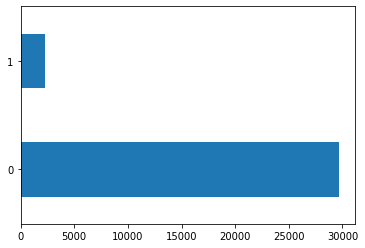

In [5]:
x_train.label.value_counts().plot(kind='barh')
plt.show()

# Preprocessing Pipeline
***

In [6]:
REMOVE_PUNCTUATION = False
LEMMATIZE = False
REMOVE_STOPWORDS = False
REMOVE_SHORT_TWEETS = 0

In [7]:
not_alpha_nor_hashtag = "[^a-zA-Z#]"
punctuation = "[{}]".format(string.punctuation)
stop_words = stopwords.words("english")

Tokenize Tweets

In [8]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

In [9]:
tokenized_training_data = x_train.tweet.apply(tokenizer.tokenize)

Remove Punctuation

In [10]:
def remove_punctuation(tokenized_tweet):
    tweet_less_punctuation = tokenized_tweet
    for word in tokenized_tweet:
        if word in punctuation:
            tweet_less_punctuation.remove(word)
    return tweet_less_punctuation

if REMOVE_PUNCTUATION:
    tokenized_training_data = tokenized_training_data.apply(remove_punctuation)

Remove stopwords

In [11]:
def remove_stopwords(tokenized_tweet):
    tweet_less_stopwords = tokenized_tweet
    for word in tokenized_tweet:
        if word in stopwords:
            tweet_less_stopwords.remove(word)
    return tweet_less_stopwords

if REMOVE_STOPWORDS:
    tokenized_training_data = tokenized_training_data.apply(remove_stopwords)

Lemmatize

In [12]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tweet(tokenized_tweet):
    for i, word in enumerate(tokenized_tweet):
        tokenized_tweet[i] = lemmatizer.lemmatize(word)
    return tokenized_tweet
        
if LEMMATIZE:
    tokenized_training_data.apply(lemmatize_tweet)

Remove Tweets Shorter Than Length `REMOVE_SHORT_TWEETS`

In [13]:
tokenized_training_data = tokenized_training_data[tokenized_training_data.str.len() >= REMOVE_SHORT_TWEETS]

# Exploratory Data Analysis
***

# Build a Baseline Model
***